# Part 1: Training a Variational Autoencoder (VAE) with the goal of generating dog images 

In [2]:
# import relevant packages and code from original source for cat generator 
import numpy as np
from glob import glob
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 
from src.model import genModel # import the VAE model
from src.vaeHelpers import *

%matplotlib inline

## Load images from folder and do train validation split

In [15]:
newTrain = False

if newTrain:
    path = '.\\Images\\'
    # get all dog images from different subfolders (different breeds of dogs for each folder):
    dogImages = np.array([f for f in glob(path + "**/*.jpg", recursive = True)]) 
    n = len(dogImages)
    
    valFrac = 0.1 # 10% for validation
    inds = np.random.permutation( n )
    trainInds, valInds = inds[ : -int(n*valFrac)], inds[-int(n*valFrac) : ]
    
    # train val split 90:10
    train, val = dogImages[trainInds], dogImages[valInds]
    
    # utilize the vaeHelpers functions and write the image names into the diff text files for storage
    writeFilesList("trainDogs.txt", train)
    writeFilesList("valDogs.txt", val)
    
else: # if already trained, just load files 
    train = readSavedFiles("trainFiles.txt")
    val = readSavedFiles("valFiles.txt")
  

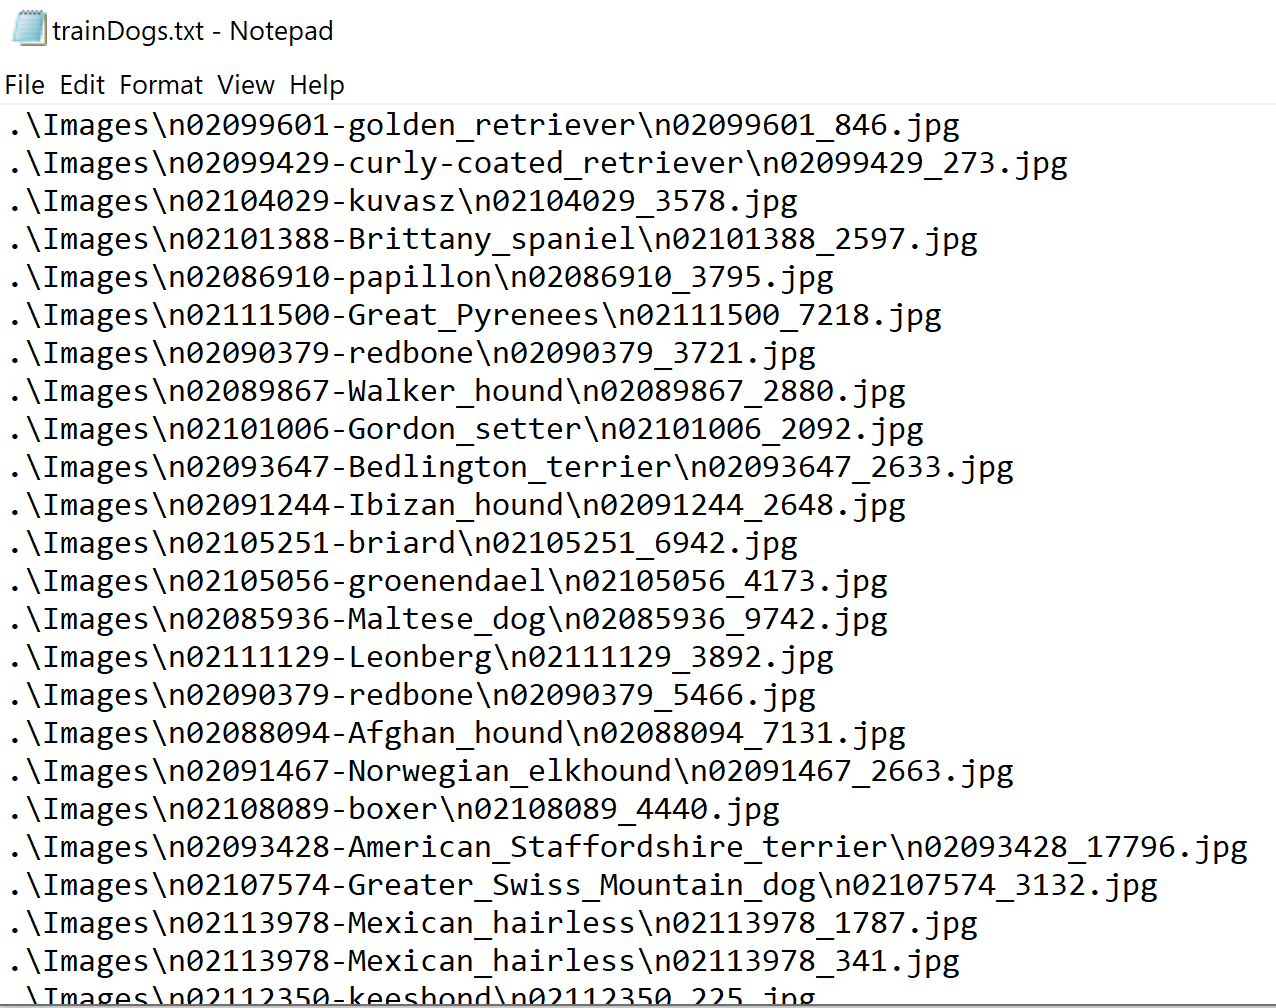

## Generate the model


In [16]:
# set params 
batchSize = 64
imgSize = 128
codeSize = 256
filters = 256

In [18]:
encoder, decoder, VAE = genModel( imgSize = imgSize, lossType = "mse", codeSize = codeSize, filters = filters)
VAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              [(None, 256), (None, 256) 4716768   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       4715471   
Total params: 9,432,239
Trainable params: 9,397,033
Non-trainable params: 35,206
_________________________________________________________________


## Train the model

In [ ]:
earlyStopper = EarlyStopping(patience = 50, verbose = 1) 
#patience argument represents the number of epochs before stopping once 
#your loss starts to increase (stops improving). This depends on your implementation, 
#if you use very small batches or a large learning rate your loss zig-zag (accuracy will be more noisy) 
# so better set a large patience argument. If you use large batches and a small learning rate your loss
# will be smoother so you can use a smaller patience argument.

checkPointer = ModelCheckpoint(filepath = "weights/dogGen.hdf5", save_best_only = True, verbose = 1)
rateReduce = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 20, cooldown = 5)

losses = VAE.fit_generator(genBatch(train, batchSize, imgSize, True), # genBatch generates mini batches for training 
                          validation_data = genBatch(val, batchSize, imgSize, False), # rnd is False for val 
                          epochs = 1000,
                          validation_steps = len(val)//batchSize,
                          steps_per_epoch = len(train)//batchSize,
                          callbacks = [earlyStopper, checkPointer])

Epoch 1/1000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

220/289 [=====================>........] - ETA: 20:15 - loss: 2310.2634

In [ ]:
# plots training loss as a function of epoch
plotLosses(losses.history) 

In [ ]:
VAE.save_weights("weights/dogGen_last.hdf5")

# Part 2: Testing the VAE models

In [ ]:
# Load model 
# set params 
imgSize = 128
codeSize = 256
filters = 128

valDogs = readSavedFiles("valDogs.txt")
encDog, decDog, dogVAE = genModel( imgSize = imgSize, codeSize = codeSize, filters = filters )
dogVAE.load_weights("weights/dogGen.hdf5")


In [ ]:
# 1. Generate dogs 
codes = np.random.normal(size = (16, codeSize)) # what are codes??
dogs = decDog.predict(codes) # decoded dog 

print("\t\tGenerated:")
plotGrid(dogs, '', (4,4)) # use VAEhelper to plot grid of 4 x 4 dogs 

In [ ]:
# 2. Inspect the dog reconstructions 
dogSample, _ = next( genBatch( valDogs, 16, imgSize, False ) )

reconstructed = dogVAE.predict( dogSample )

print( "\n\t\tOriginal:" )
plotGrid( dogSample, "", size = (4, 4) )

print( "\n\t\tReconstruction:" )
plotGrid( reconstructed, "", size = (4, 4) )